<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/5_Linear_regression/5_5_Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 5: Linear regression

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 5.5 Weighted Regression

Because regression cost functions are *summable over individual points* we can - as we will see in this Section - weight individual points in order to emphasize or de-emphasize their importance to a regression model.  This is called *weighted regression*.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_5_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/5_Linear_regression/chapter_5_datasets
else:
    print('chapter_5_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_5_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/5_Linear_regression/chapter_5_library
else:
    print('chapter_5_library already cloned!')

# clone videos
if not Path('chapter_5_videos').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/5_Linear_regression/chapter_5_videos
else:
    print('chapter_5_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_5_library')
sys.path.append('./chapter_5_datasets') 
sys.path.append('./chapter_5_videos') 

# import section helper
import section_5_5_helpers

# dataset paths
data_path_1 = 'chapter_5_datasets/galileo_ramp_data.csv'
data_path_2 = 'chapter_5_datasets/weighting_regression_data.csv'

# video paths
video_path_1 = 'chapter_5_videos/animation_4.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_5_datasets already cloned!
chapter_5_library already cloned!
chapter_5_videos already cloned!


##  Dealing with duplicates

Imagine we have a linear regression dataset $\left(x_1,y_1\right),\left(x_2,y_2\right),...,\left(x_P,y_P\right)$ that contains multiple copies of the same point.  This can occur in a variety of contexts including

    
- experimental data (e.g., in physics, medicine, etc.,): if a repeated experiment produces  the same result
    
    
- metadata-type datasets (e.g., census, customer databases): due to necessary / helpful pre-processing that quantizes (bins) input features in order to make human-in-the-loop analysis of the data / modeling easier
    
    
In such instances 'duplicate' datapoints should not be thrown away, since they accurately represent the true phenomenon under study.

For example, in the figure below we show a raw set of data from a modern reenactment of Galileo's famous experiment where - in order to quantify the effect of gravity - he repeatedly rolled a ball down a ramp to determine the relationship between distance and amount of time it takes an object to fall to the ground.  Below we show a plot of this dataset, which consists of multiple trials of the same experiment, where each output's numerical value has been rounded to two decimal places.  Note that this is the raw version of the data [shown in example 4 of this set of notes](https://jermwatt.github.io/mlrefined/blog_posts/12_Nonlinear_intro/12_1_Introduction_nonlinear_regression.html).  There are multiple datapoints here that are *duplicates*, which we denote visually by scaling the dot representing each point in the image - the larger the dot, the more duplicate points it represents.

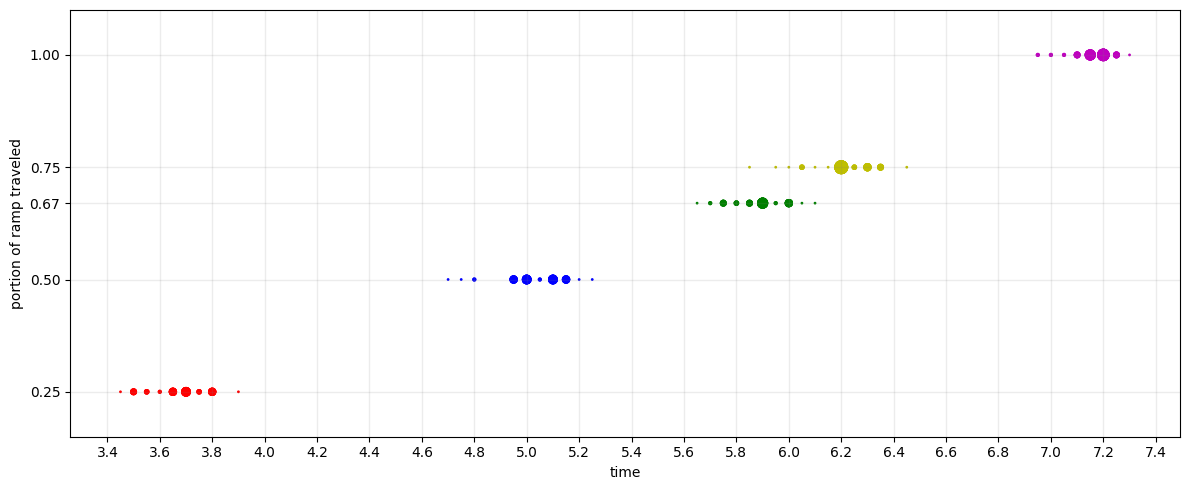

In [2]:
# show demo
demo1 = section_5_5_helpers.weighted_regression_static_visualizer()
demo1.plot_it(data_path_1)

If we examine any regression cost function over such a dataset (i.e., one with repeated entries) we can see that it naturally *collapses* into a weighted version itself.  For example, let us examine the Least Squares cost and suppose that our first two datapoints  $\left(x_1,\,y_1\right)$ and $\left(x_2,\,y_2\right)$ are *identical*.  In this instance - using our `model` notation - the first two summands of our cost function (in the first two datapoints) can be combined since they will always take on the same value

\begin{equation}
\begin{array}
\
\frac{1}{P}\sum_{p=1}^P \left(\text{model}\left(x_p,\mathbf{w}\right) - y_p\right)^2   \\
= \frac{1}{P}\,2\,\left(\text{model}\left(x_1,\mathbf{w}\right) - y_1\right)^2 + \frac{1}{P}\,0\,\left(\text{model}\left(x_2,\mathbf{w}\right) - y_2\right)^2  + \frac{1}{P}\,\sum_{p=3}^P \left(\text{model}\left(x_p,\mathbf{w}\right) - y_p\right)^2   \\
= \frac{1}{P}\,2\,\left(\text{model}\left(x_1,\mathbf{w}\right) - y_1\right)^2 + \frac{1}{P}\,\sum_{p=3}^P \left(\text{model}\left(x_p,\mathbf{w}\right) - y_p\right)^2   \\
\end{array}
\end{equation}

Here we can see that the cost function naturally collapses - in the sense that we can combine summands containing repeated points - so that a repeated point in a dataset is represented *in the cost function* by a single weighted summand.  

Of course this holds more generally as well.  If we examined a regression cost function of a dataset having any number of identical points then we can collapse the summands of this cost for each set of identical points just as we have seen here.

In general this leads to the notion that each term in a regression cost can be *weighted* to reflect repeated points.  We can write such a *weighted regression* Least Squares as

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P \beta_p \left(\text{model}\left(x_p,\mathbf{w}\right) - y_p\right)^2
\end{equation}

where $\beta_1,\,\beta_2,\,...,\,\beta_P$ are *point-wise* weights.  That is, a unique point $\left(x_p,\,y_p\right)$ in the dataset has weight $\beta_p = 1$ whereas if this point is repeated $R$ times in the dataset then one instance of it will have weight $\beta_p = R$ while the others have weight $\beta_p = 0$.

Since these weights are fixed (i.e., they are *not* parameters that need to be tuned, like $\mathbf{w}$) we can minimize a weighted regression cost precisely as we would any other e.g,. via a local optimization scheme like gradient descent or Newton's method.

In [3]:
# a Python implementation of the weighted least squares cost function
# setup to compute over mini-batches if desired
def least_squares(w,x,y,beta,iter):
    # get batch of points
    x_p = x[:,iter]
    y_p = y[:,iter]
    beta_p = beta[:,iter]

    # compute cost over batch
    cost = np.sum((beta*model(x_p,w) - y_p)**2)
    return cost/float(np.size(y_p))

##  Weighting points by confidence

Weighted regression can also be employed when - given knowledge of the process generating a dataset - we want to weight each point based on our *confidence on the trustworthiness* of each datapoint.  For example if our dataset came in two batches - one batch from a trustworthy source and another from a less trustworthy source (where some datapoints could be noisy or fallacious) - we would want to weight datapoints from the trustworthy source more in our final regression.  We can do this very easily using precisely the weighted regression paradigm introduced above, only now we *set the weights $\beta_1,\,\beta_2,\,...,\,\beta_P$ ourselves based on our confidence of each point*.  If we believe that a point is very trustworthy we can set its corresponding weight $\beta_p$ closer to $1$, and the more untrustworthy we find a point the smaller we set $\beta_p$ in the range $0 \leq \beta_p \leq 1$ where $\beta_p = 0$ implies we do not trust the point at all.  In making these weight selections we of course determine *how important each datapoint is* in the training of the model.

Below we show the result of increasing the confidence / weight $\beta_p$ on a *single point* in a toy dataset, and how this effects a fully trained regression model on a toy linear regression dataset.  This single point is colored red and we show its diameter increasing and as we increase its corresponding weight $\beta_p$.  With each weighting a weighted Least Squares cost is completely minimized over the entire dataset, and resulting line fit to data (and shown in black).  The higher the weighting of this single point, the more we incentivize a linear regressor to fit to it.   If we increase its weight enough the fully trained regression model naturally starts fitting to this single datapoint alone (disregarding all other points).

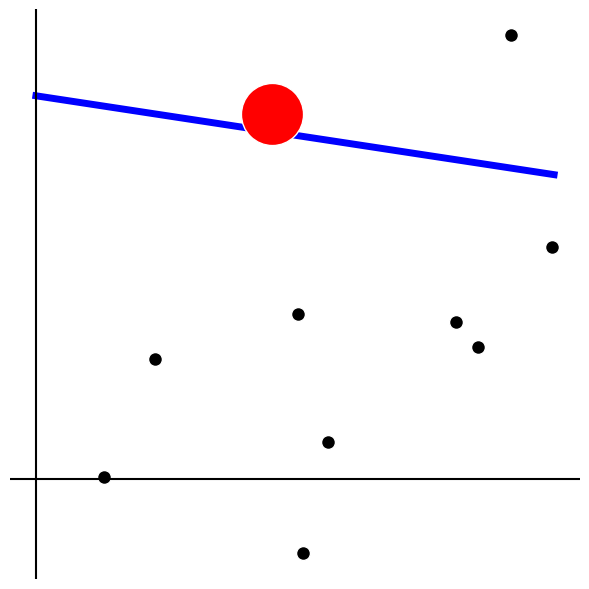

In [4]:
# show demo
demo2 = section_5_5_helpers.weighted_regression_animation_visualizer()
demo2.animate_weighting(video_path_1,data_path_2,num_slides = 200,special_ind=9,fps=10)

In [5]:
show_video(video_path_1, width=400)